In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time

2025-06-23 15:22:01.639153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750692121.930700      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750692122.011505      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# PARAMETERS
INPUT_HEIGHT = 128
INPUT_WIDTH = 128

INPUT_SHAPE = (INPUT_HEIGHT, INPUT_WIDTH, 1)

latent_dims = 64



In [4]:
augmenter = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.05, name=f"random_rotation", fill_mode="constant"),
        tf.keras.layers.RandomZoom(0.05, name=f"random_zoom", fill_mode="constant"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, name=f"random_translation", fill_mode="constant"),
        tf.keras.layers.RandomCrop(INPUT_HEIGHT, INPUT_WIDTH, name=f"random_crop")
])

augmenter.summary()

2025-06-23 15:22:26.319907: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ ?                           │     0 (unbuilt) │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_crop (RandomCrop)             │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
class Preprocessor(tf.keras.Model):
    def __init__(self):
        super().__init__(name="preprocessor")
        self.augmenter = tf.keras.Sequential([
            tf.keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH, name=f"{self.name}_resizer"),
            tf.keras.layers.Rescaling(scale=1./255, name=f"{self.name}_rescaler"),
        ], name=f"{self.name}_augmenter")

    def call(self, inputs):
        return self.augmenter(inputs)


In [9]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization

In [10]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dims):
    super().__init__(name="encoder")

    self.latent_dims = latent_dims

    # layers
    self.preprocess = Preprocessor()
    # 128 x 128 x 1
    self.conv1 = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv1')
    self.bnorm1 = BatchNormalization(name="encoder_bnorm1")
    self.mpool1 = MaxPool2D(name='encoder_mpool1')

    # 64 x 64 x 16
    self.conv2 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv2')
    self.bnorm2 = BatchNormalization(name="encoder_bnorm2")
    self.mpool2 = MaxPool2D(name='encoder_mpool2')

    # 32 x 32 x 32
    self.conv3 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv3')
    self.bnorm3 = BatchNormalization(name="encoder_bnorm3")
    self.mpool3 = MaxPool2D(name='encoder_mpool3')

    # 16 x 16 x 64
    self.conv4 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv4')
    self.bnorm4 = BatchNormalization(name="encoder_bnorm4")
    self.mpool4 = MaxPool2D(name='encoder_mpool4')

    # 8 x 8 x 128
    self.flatten = Flatten(name='encoder_flatten')

    self.dense1 = Dense(2 * self.latent_dims, name='encoder_dense1')
    # 2 x self.latent_dims


    self.logvar = Dense(self.latent_dims, name='encoder_logvar')
    self.mu = Dense(self.latent_dims, name='encoder_mu')
    self.sigma = Lambda(lambda x: tf.exp(0.5*x), name='encoder_sigma')
    self.logvar_clip = Lambda(lambda x: tf.clip_by_value(x, -20.0, 5.0), name='logvar_clip')


  def encode(self, inputs, preprocess=True):
    # print the shape of the input
    # print(f"Shape of input to encoder: {inputs.shape}")
    p = self.preprocess(inputs) if preprocess else inputs
    x=self.conv1(p); x=self.bnorm1(x); x=self.mpool1(x)
    x=self.conv2(x); x=self.bnorm2(x);  x=self.mpool2(x)
    x=self.conv3(x); x=self.bnorm3(x);  x=self.mpool3(x)
    x=self.conv4(x); x=self.bnorm4(x);  x=self.mpool4(x)
    x=self.flatten(x)
    x=self.dense1(x)
    # print(f"Shape of output from encoder: {x.shape}")

    logvar = self.logvar(x)
    logvar = self.logvar_clip(logvar)

    return self.mu(x), logvar, self.sigma(logvar), p


  def call(self, inputs):
    return self.encode(inputs)

  def summary(self, input_shape):
    x = tf.keras.layers.Input(shape=input_shape)
    model = tf.keras.Model(inputs=[x], outputs=self.call(x))
    return model.summary()


In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dims):
        super().__init__(name='decoder')

        self.latent_dims = latent_dims

        # layers
        self.dense1 = Dense(8 * 8 * 128, activation='relu', name='decoder_dense1')
        self.reshape1 = Reshape((8, 8, 128), name='decoder_reshape1')

        # 8 x 8 x 128 -> 16 x 16 x 64
        self.convT1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT1')
        self.bnorm1 = BatchNormalization(name="decoder_bnorm1")

        # 16 x 16 x 64 -> 32 x 32 x 32
        self.convT2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT2')
        self.bnorm2 = BatchNormalization(name="decoder_bnorm2")

        # 32 x 32 x 32 -> 64 x 64 x 16
        self.convT3 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT3')
        self.bnorm3 = BatchNormalization(name="decoder_bnorm3")

        # 64 x 64 x 16 -> 128 x 128 x 1
        self.convT4 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid', name='decoder_convT4')

        # binary output
        # self.binaryOutput = Lambda(lambda x: tf.cast(x > 0.5, tf.float32), name="decoder_binary_lambda")

    def decode(self, z):
        x = self.dense1(z)
        x = self.reshape1(x)

        x = self.convT1(x); x = self.bnorm1(x)
        x = self.convT2(x); x = self.bnorm2(x)
        x = self.convT3(x); x = self.bnorm3(x)
        x = self.convT4(x);
        # x = self.binaryOutput(x)


        return x

    def call(self, inputs):
        return self.decode(inputs)

    def summary(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()


In [12]:
encoder = Encoder(latent_dims=latent_dims) # Example latent_dims
print("Encoder Summary:")
encoder.summary(input_shape=INPUT_SHAPE)

decoder = Decoder(latent_dims=latent_dims)
print("\nDecoder Summary:")
decoder.summary(input_shape=(latent_dims,))

Encoder Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ preprocessor              │ (None, 128, 128, 1)    │              0 │ input_layer[0][0]      │
│ (Preprocessor)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv1 (Conv2D)    │ (None, 128, 128, 16)   │            160 │ preprocessor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm1            │ (None, 128, 128, 16)   │             64 │ encoder_conv1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool1            │ (None, 64, 64, 16)     │              0 │ encoder_bnorm1[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv2 (Conv2D)    │ (None, 64, 64, 32)     │          4,640 │ encoder_mpool1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm2            │ (None, 64, 64, 32)     │            128 │ encoder_conv2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool2            │ (None, 32, 32, 32)     │              0 │ encoder_bnorm2[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv3 (Conv2D)    │ (None, 32, 32, 64)     │         18,496 │ encoder_mpool2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm3            │ (None, 32, 32, 64)     │            256 │ encoder_conv3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool3            │ (None, 16, 16, 64)     │              0 │ encoder_bnorm3[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv4 (Conv2D)    │ (None, 16, 16, 128)    │         73,856 │ encoder_mpool3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm4            │ (None, 16, 16, 128)    │            512 │ encoder_conv4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool4            │ (None, 8, 8, 128)      │              0 │ encoder_bnorm4[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_flatten (Flatten) │ (None, 8192)           │              0 │ encoder_mpool4[0][0]   │
├──────────────────────

 Total params: 1,163,328 (4.44 MB)

 Trainable params: 1,162,848 (4.44 MB)

 Non-trainable params: 480 (1.88 KB)


Decoder Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense1 (Dense)               │ (None, 8192)                │         532,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_reshape1 (Reshape)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT1 (Conv2DTranspose)     │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm1 (BatchNormalization)  │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT2 (Conv2DTranspose)     │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm2 (BatchNormalization)  │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT3 (Conv2DTranspose)     │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm3 (BatchNormalization)  │ (None, 64, 64, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT4 (Conv2DTranspose)     │ (None, 128, 128, 1)         │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,953 (2.40 MB)

 Trainable params: 629,729 (2.40 MB)

 Non-trainable params: 224 (896.00 B)

In [13]:
class ReconstructionLoss(tf.keras.layers.Layer):
  def __init__(self):
    super(ReconstructionLoss, self).__init__(name="reconstruction_loss")
    self.epsilon = tf.keras.backend.epsilon() # Get a small epsilon value


  def call(self, inputs):
    x = inputs[0]
    recon_x = inputs[1]

    recon_x = tf.clip_by_value(recon_x, self.epsilon, 1.0 - self.epsilon)


      
    tf.debugging.check_numerics(x, 'recons x contains NaN or Inf')
    tf.debugging.check_numerics(recon_x, 'reconx contains NaN or Inf')


    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x), axis=[1,2])
    recon_loss = tf.reduce_mean(recon_loss)

    self.add_loss(recon_loss)

    return recon_loss

In [14]:
class KLLoss(tf.keras.layers.Layer):
  def __init__(self, beta=2.0):
    super(KLLoss, self).__init__()

    self.beta = beta

  def call(self, inputs):
    mu = inputs[0]
    logvar = inputs[1]
    
      
    tf.debugging.check_numerics(mu, 'mu klloss contains NaN or Inf') 
    tf.debugging.check_numerics(logvar, 'logvar klloss contains NaN or Inf')

    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    kl_loss = kl_loss * self.beta

    self.add_loss(kl_loss)
    return kl_loss

In [15]:
# Sampler

class Sampler(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="sampler")

  def call(self, inputs):
    mu = inputs[0]
    sigma = inputs[1]

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))

    # reparameterize
    output =  mu + tf.multiply(sigma, epsilon)

    # print(f"Shape of output from sampler: {output.shape}")
    return output



In [16]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__(name="bvae")

    self.latent_dims = latent_dims

    # layers
    self.encoder = Encoder(self.latent_dims)
    self.decoder = Decoder(self.latent_dims)

    self.sampler = Sampler()

    self.reconstruction_loss = ReconstructionLoss()
    self.kl_loss = KLLoss(beta=4.0)

    # trackers
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

  def get_config(self):
    config = super().get_config()
    config.update({
        "latent_dims": self.latent_dims,
    })
    return config

  @classmethod
  def from_config(cls, config):
    # Extract latent_dims from the config
      latent_dims = config.pop('latent_dims')
      # Remove other keys added by Keras during saving if they are not needed for __init__
      config.pop('name', None)
      config.pop('trainable', None)
      config.pop('dtype', None)
      # Create an instance of the class using the extracted latent_dims
      return cls(latent_dims=latent_dims, **config)



  def call(self, inputs):
    mu, logvar, sigma, x = self.encoder(inputs)

    tf.debugging.check_numerics(mu, 'Encoder mu contains NaN or Inf')
    tf.debugging.check_numerics(logvar, 'Encoder logvar contains NaN or Inf')
    tf.debugging.check_numerics(sigma, 'Encoder sigma contains NaN or Inf')
    tf.debugging.check_numerics(x, 'Preprocessor output contains NaN or Inf')


    # print(mu, logvar, x)
    z = self.sampler([mu, sigma])
    # print(f"Shape of z: {z.shape}")
    recon_x = self.decoder(z)

    kl_loss = self.kl_loss([mu, logvar])
    reconstruction_loss = self.reconstruction_loss([x, recon_x])

    return recon_x, kl_loss, reconstruction_loss

  @property
  def metrics(self):
      return [
          self.loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
    # print(f"Shape of input data in train_step: {data.shape}")

    with tf.GradientTape() as tape:
      recon_x, kl_loss, reconstruction_loss = self(data)
      total_loss = reconstruction_loss + kl_loss

      # update the trackers
      self.loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      # gradients
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        m.name: m.result() for m in self.metrics
    }

  def test_step(self, data):
    recon_x, kl_loss, reconstruction_loss = self(data)
    total_loss = reconstruction_loss + kl_loss
    self.loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        m.name: m.result() for m in self.metrics
    }

  def encode(self, inputs, preprocess=True):
    return self.encoder.encode(inputs, preprocess=preprocess)

  def decode(self, inputs):
    return self.decoder.decode(inputs)

  def sample(self, mu, sigma):
    return self.sampler([mu, sigma])

  def calculate_reconstruction_loss(self, inputs):
    return self.reconstruction_loss(inputs)

  def calculate_kl_loss(self, inputs):
    return self.kl_loss(inputs)






In [ ]:
class BetaVaeParameterUpdater(tf.keras.callbacks.Callback):
  def __init__(self, delta, limit):
    super().__init__()
    self.delta = delta
    self.limit = limit

  @tf.function
  def update_beta(self):
    beta = self.model.kl_loss.beta
    beta = tf.math.maximum(beta - self.delta, self.limit)

  def on_epoch_end(self, epoch, logs=None):
    self.update_beta()

In [ ]:
model = BVAE(latent_dims=latent_dims)
print("latent_dims:", latent_dims)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))



In [ ]:
dummy_input = tf.zeros((1, INPUT_HEIGHT, INPUT_WIDTH, 1))
model(dummy_input)
model.summary()


In [17]:
images_path = "/kaggle/input/images/images"

In [37]:
images = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels="inferred",
    label_mode= "int",
    color_mode='grayscale',
    image_size=(128, 128),
    batch_size=16,
    shuffle=True, # Ensure shuffling for random split
    seed=42 # Optional: Set seed for reproducible split
)

# augmentation
# augmentations = 2
# for i in range(augmentations):
aug_images = images.map(lambda x, y: (augmenter(x, training=True), y))
    # add to the training set
images = images.concatenate(aug_images)

# Calculate the size of the dataset
dataset_size = tf.data.experimental.cardinality(images).numpy()


train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset using take and skip
train_ds = images.take(train_size)
test_ds = images.skip(train_size)

Found 1901 files belonging to 30 classes.


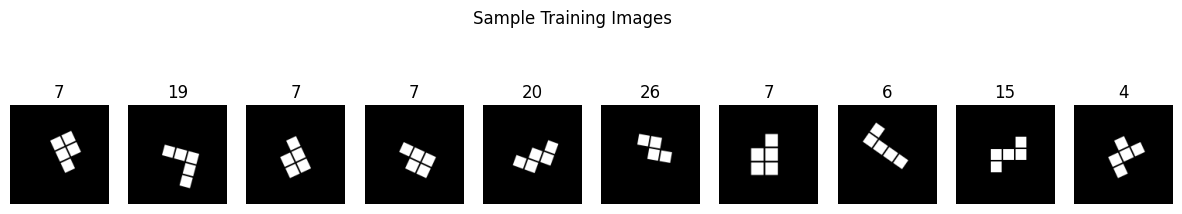

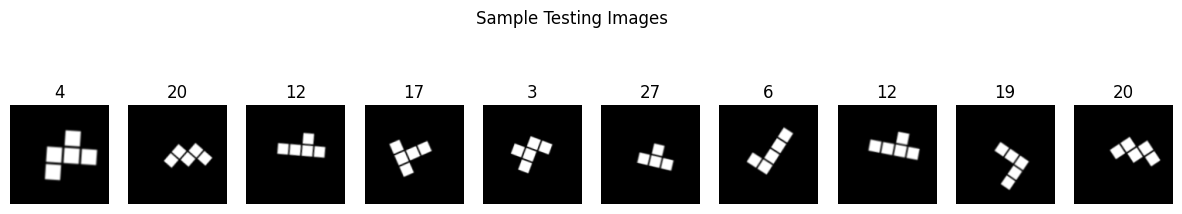

In [41]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_dataset_samples(dataset, title, num_images=10):
    images_batch, labels_batch = next(iter(dataset.take(1)))
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
        plt.title(str(labels_batch[i].numpy()))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_dataset_samples(train_ds, 'Sample Training Images')
plot_dataset_samples(test_ds, 'Sample Testing Images')


In [ ]:
import matplotlib.pyplot as plt

beta_updater_callback = BetaVaeParameterUpdater(delta=2e-4, limit=0.0) # Example values

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     patience=50,
                                                     cooldown=25,
                                                     min_lr=1e-5,
                                                     min_delta=1.0,
                                                     verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=100,
                                                           restore_best_weights=True,
                                                           min_delta=1.0,
                                                           verbose=1)
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(
    train_ds,
    epochs=20000, # Adjust the number of epochs as needed
    validation_data=test_ds,
    callbacks=[beta_updater_callback, early_stop_callback, terminate_on_nan] # Add the callback
)

# Plot training history (optional)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
loaded_model_path = "/kaggle/input/bvae_64dims/keras/default/1/bvae_model_ldims_64.keras"
loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects={'BVAE':BVAE})

In [21]:
loaded_model.summary()

Model: "bvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │       1,163,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         629,953 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampler (Sampler)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction_loss                  │ ?                           │               0 │
│ (ReconstructionLoss)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kl_loss (KLLoss)                     │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,378,437 (20.52 MB)

 Trainable params: 1,792,577 (6.84 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 3,585,156 (13.68 MB)

In [23]:
model = loaded_model

In [ ]:
# save the model
model.save(f"bvae_model_ldims_{latent_dims}_{round(time())}_new.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


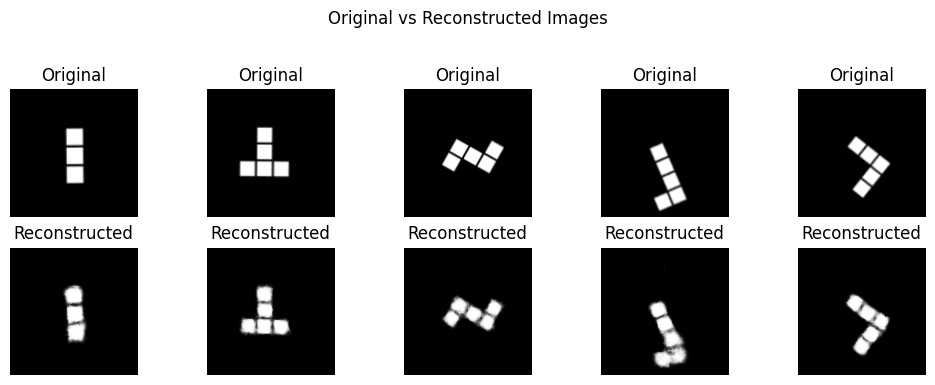

In [25]:
import matplotlib.pyplot as plt
# Select a few images from the test dataset to reconstruct
num_images_to_reconstruct = 5

# Take a batch from the test dataset
for test_batch in test_ds.take(1):
    # Select the first `num_images_to_reconstruct` images from the batch
    original_images = test_batch[:num_images_to_reconstruct]

# Get the reconstructed images from the model
# Ensure the model is built by passing a sample input
model.predict(original_images[:1])
reconstructed_images, _, _ = model(original_images)


# Plot the original and reconstructed images side by side
plt.figure(figsize=(10, 4))
for i in range(num_images_to_reconstruct):
    # Plot original image
    plt.subplot(2, num_images_to_reconstruct, i + 1)
    plt.imshow(tf.squeeze(original_images[i]).numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(2, num_images_to_reconstruct, i + 1 + num_images_to_reconstruct)
    plt.imshow(tf.squeeze(reconstructed_images[i]).numpy(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle('Original vs Reconstructed Images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap of title
plt.show()

In [52]:
import matplotlib.pyplot as plt
# Select a few images from the test dataset to reconstruct
num_images_to_reconstruct = 1

# Take a batch from the test dataset
for test_batch_img, _ in test_ds.take(1):
    # Select the first `num_images_to_reconstruct` images from the batch
    to_encode_images = test_batch[:num_images_to_reconstruct]
to_encode_images

<tf.Tensor: shape=(1, 128, 128, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [53]:
to_encode_images.shape

TensorShape([1, 128, 128, 1])

In [55]:
encoded_images = model.encode(to_encode_images)
mu, log, sigma, recon = encoded_images

mu

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 2.43236828e+00,  7.41249561e-01,  5.40322125e-01,
        -1.46533990e+00, -1.28387600e-01, -8.80762994e-01,
         9.74027961e-02, -2.25668001e+00,  1.70009148e+00,
         3.23174089e-01, -8.59926268e-02, -5.09728968e-01,
         2.00829044e-01,  4.17484306e-02, -1.46682310e+00,
        -1.66616589e-03,  1.00042924e-01, -2.39632353e-01,
        -3.36365700e-01,  7.13054717e-01, -4.49306279e-01,
        -8.37512761e-02, -1.87245443e-01, -2.27097583e+00,
         2.36005470e-01, -1.49471194e-01, -4.83710051e-01,
        -8.05191174e-02, -1.47214746e+00,  3.24870795e-02,
         1.27048776e-01,  1.71429515e-02,  4.67071891e-01,
        -9.59109724e-01,  1.97150901e-01, -5.95756233e-01,
        -2.06620121e+00,  9.54068676e-02,  1.25374526e-01,
         8.05077195e-01, -6.33257568e-01,  4.89512175e-01,
         1.86121321e+00, -9.31787640e-02, -1.00391693e-01,
         3.98420453e-01,  1.33998275e+00, -3.16685587e-01,
       

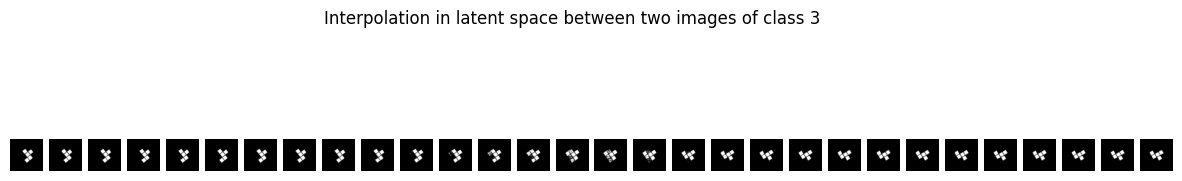

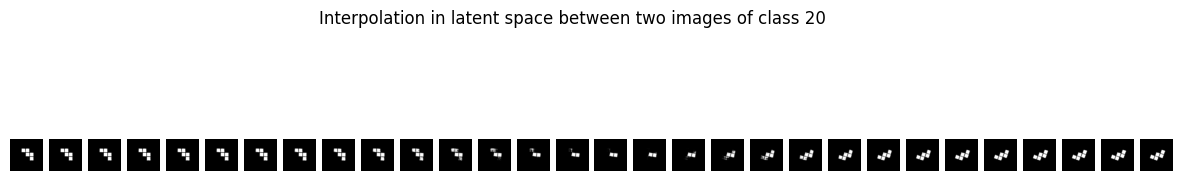

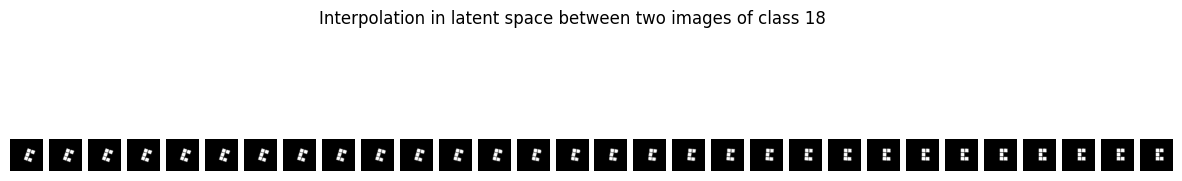

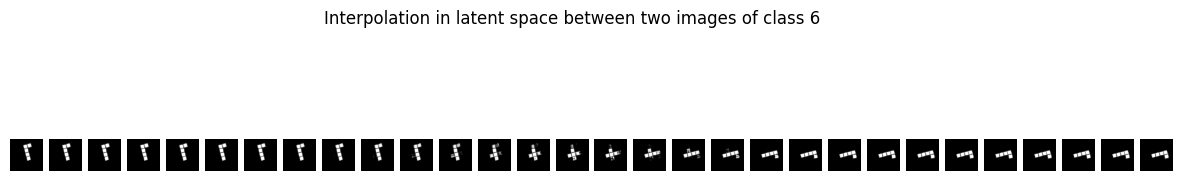

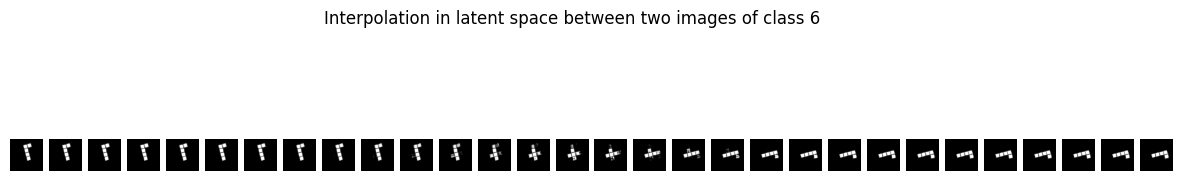

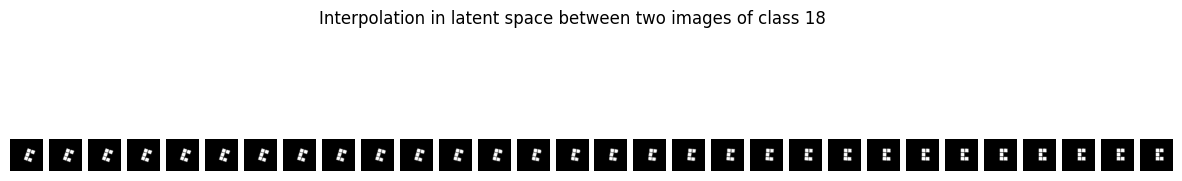

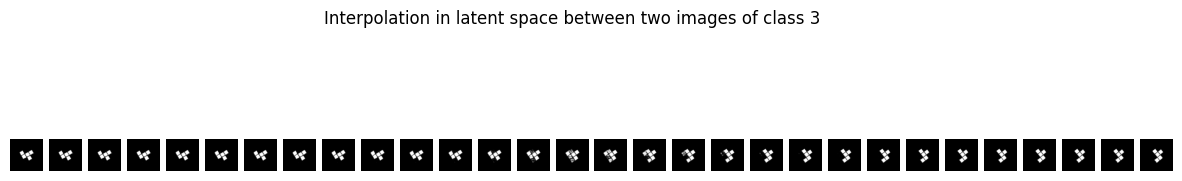

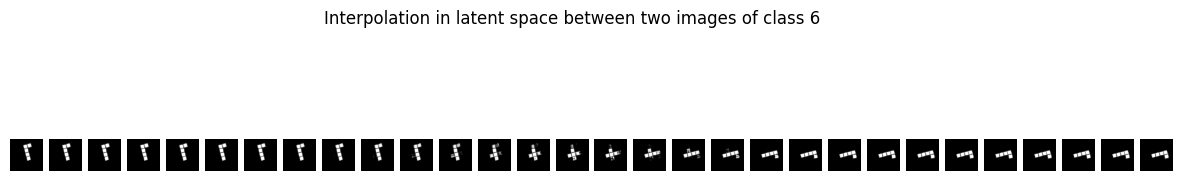

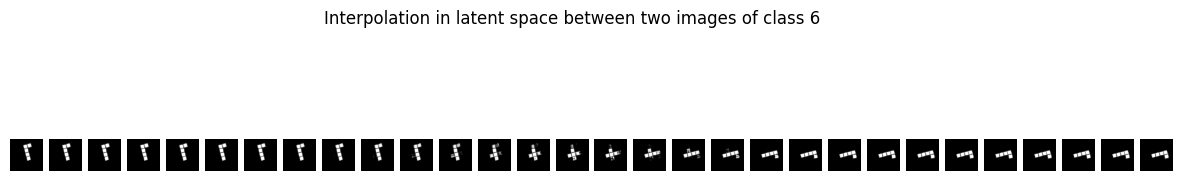

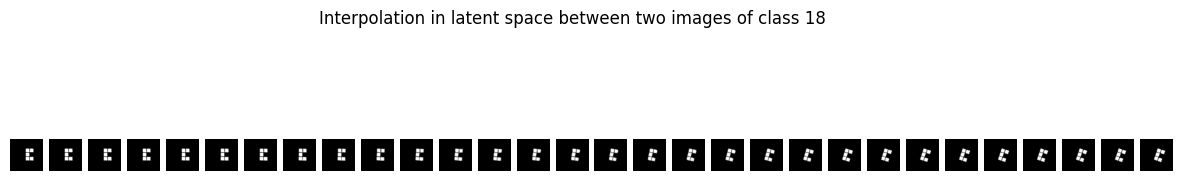

In [60]:
train_images, train_labels = next(iter(train_ds.take(1)))
train_mu, _, _, _ = model.encode(train_images)
train_latents = train_mu.numpy()
labels = train_labels.numpy()

unique_classes, counts = np.unique(labels, return_counts=True)
valid_classes = unique_classes[counts >= 2]

for _ in range(10):
    cls = np.random.choice(valid_classes)
    class_indices = np.where(labels == cls)[0]
    idx1, idx2 = np.random.choice(class_indices, size=2, replace=False)

    latent1 = train_latents[idx1]
    latent2 = train_latents[idx2]
    direction = latent2 - latent1

    steps = 30
    interpolated_latents = np.array([latent1 + (direction * t / (steps - 1)) for t in range(steps)])
    reconstructed_images = model.decode(interpolated_latents).numpy()

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Interpolation in latent space between two images of class {cls}')
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plt.imshow(tf.squeeze(reconstructed_images[i]), cmap='gray')
        plt.axis('off')
    plt.show()

Generating images by varying latent dimension 0


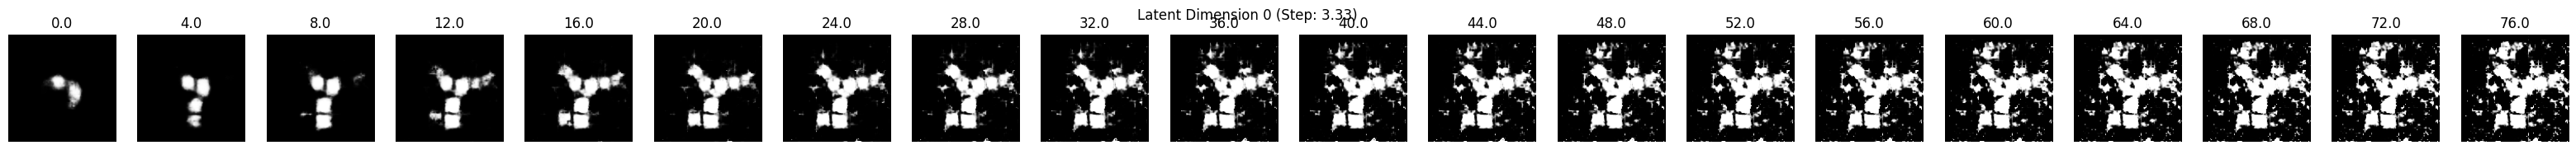

Generating images by varying latent dimension 1


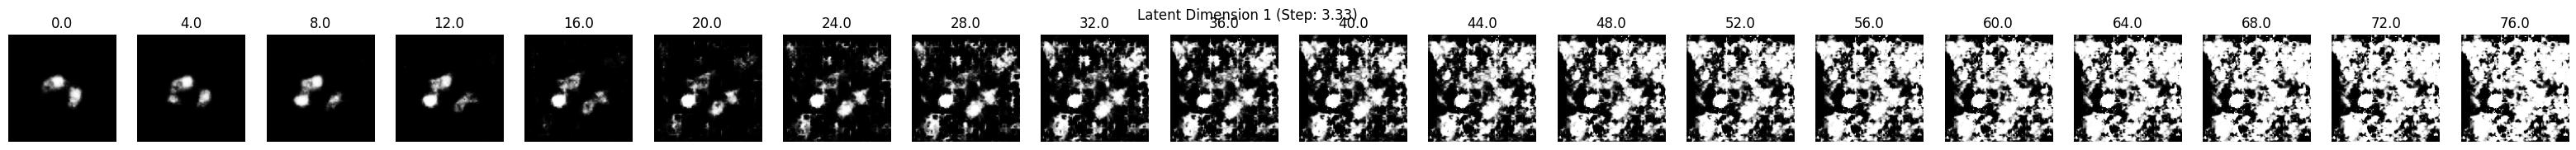

Generating images by varying latent dimension 2


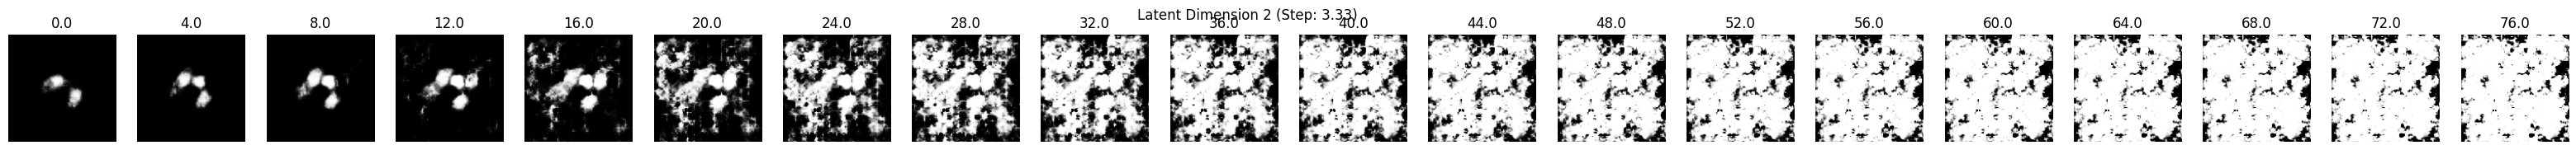

Generating images by varying latent dimension 3


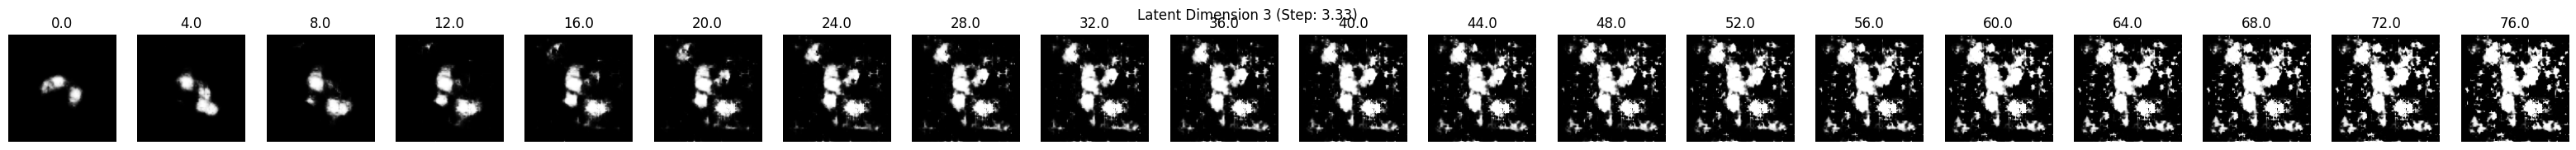

Generating images by varying latent dimension 4


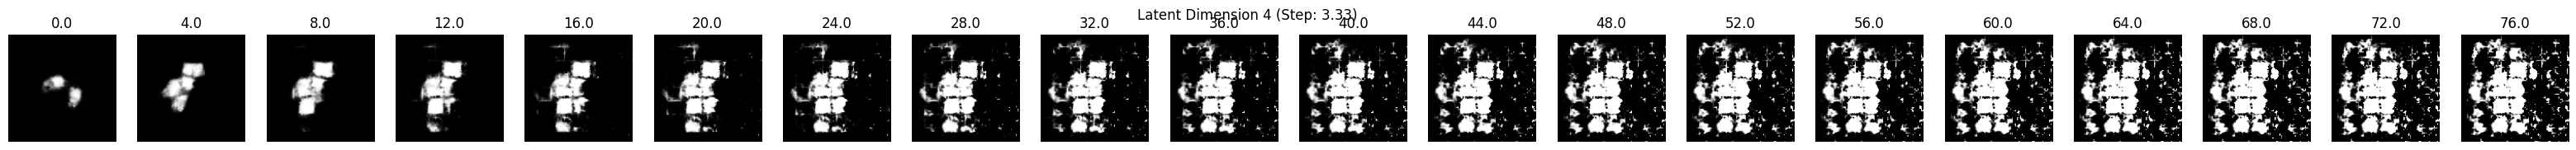

Generating images by varying latent dimension 5


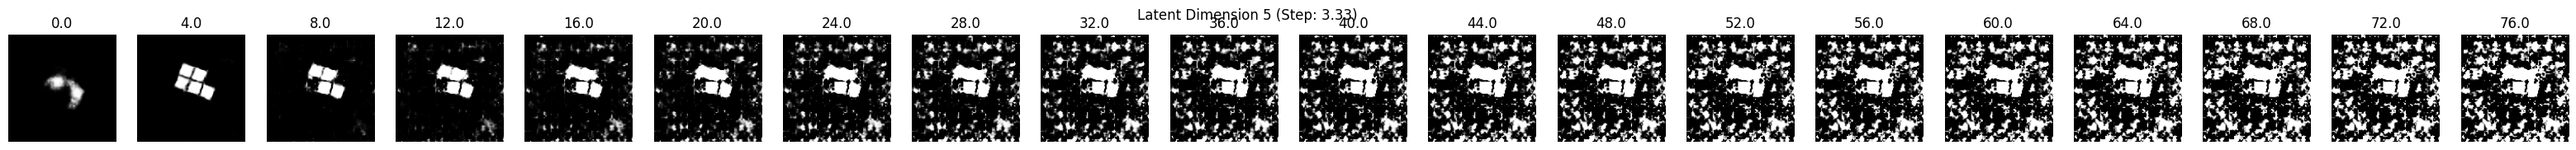

Generating images by varying latent dimension 6


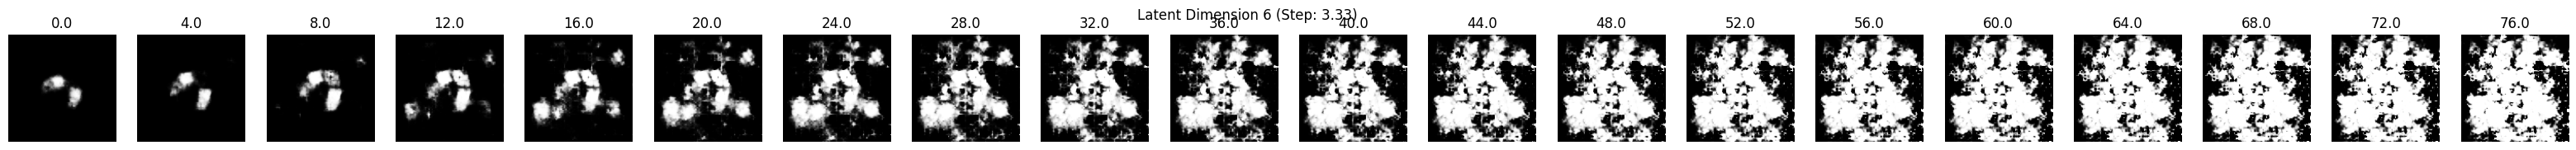

Generating images by varying latent dimension 7


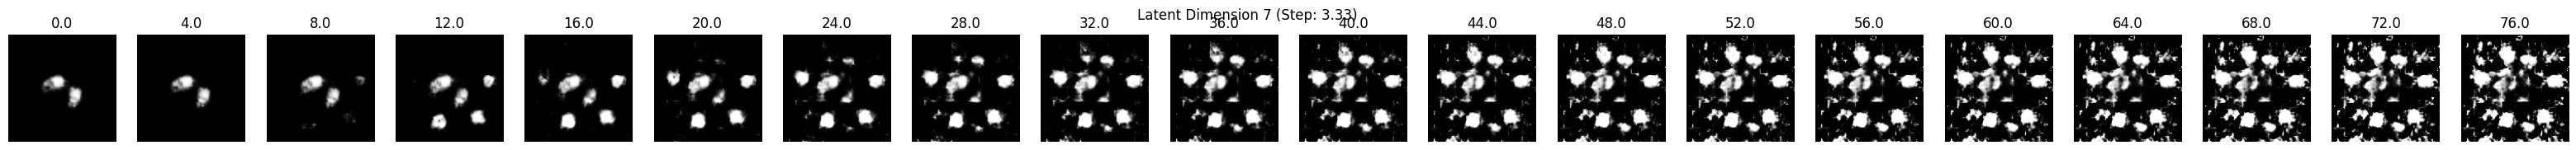

Generating images by varying latent dimension 8


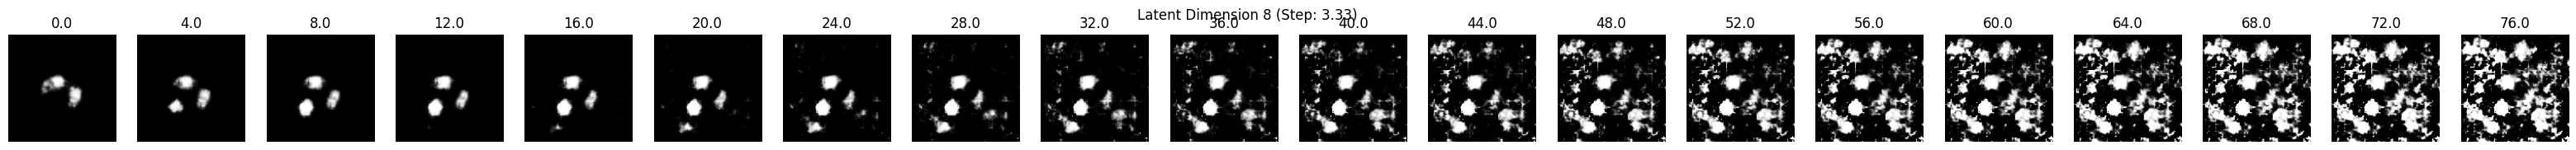

Generating images by varying latent dimension 9


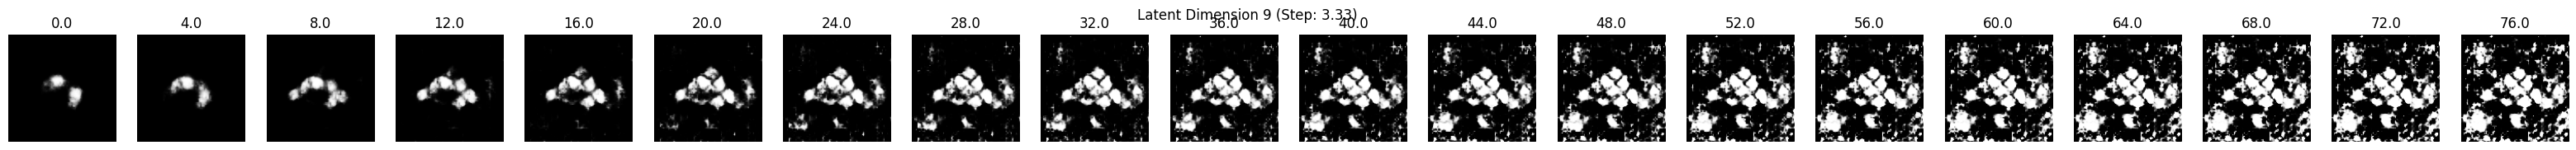

Generating images by varying latent dimension 10


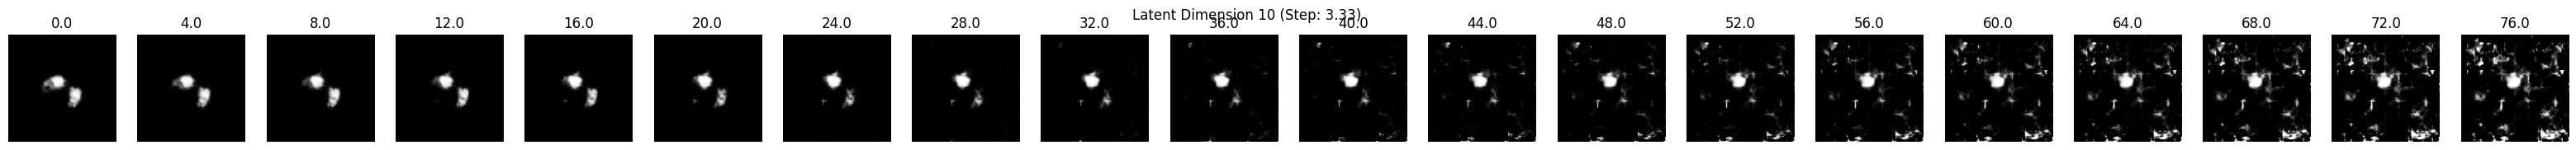

Generating images by varying latent dimension 11


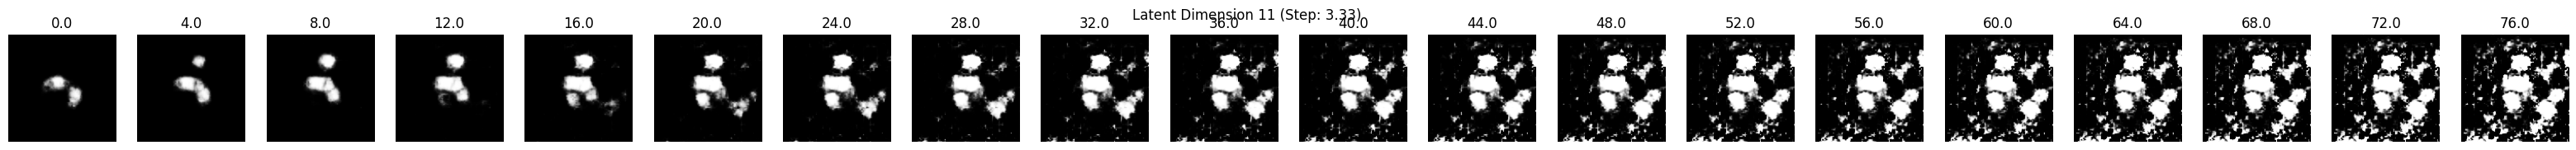

Generating images by varying latent dimension 12


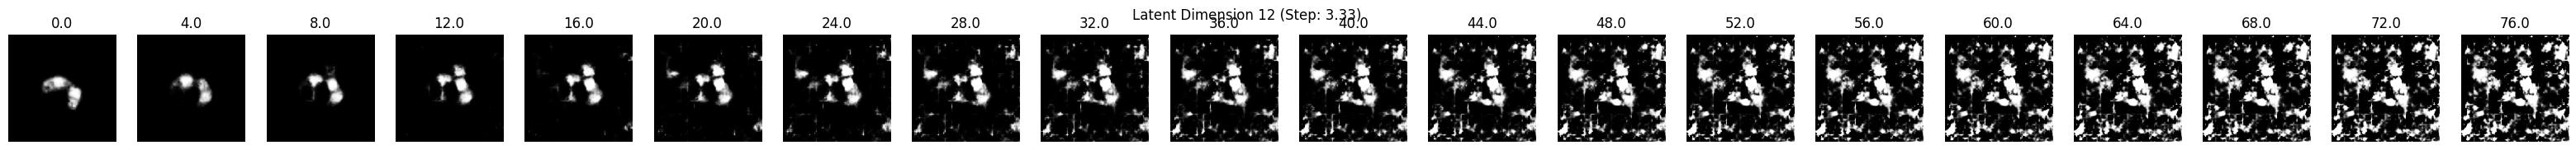

Generating images by varying latent dimension 13


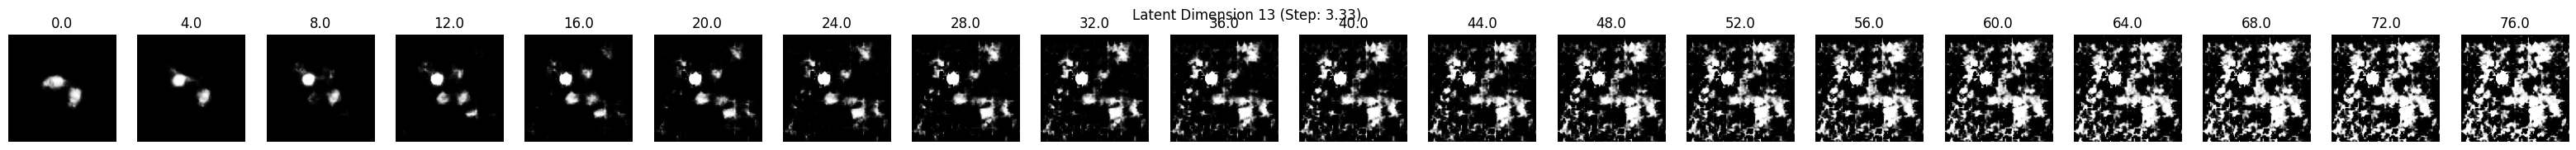

Generating images by varying latent dimension 14


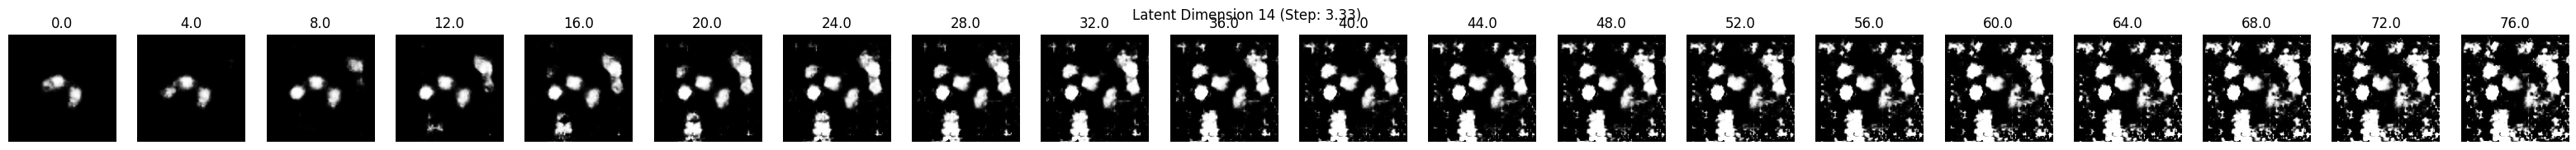

Generating images by varying latent dimension 15


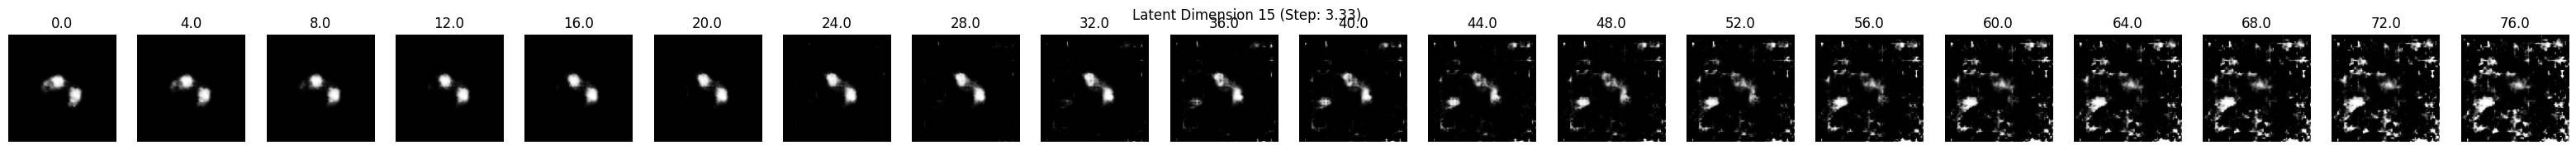

Generating images by varying latent dimension 16


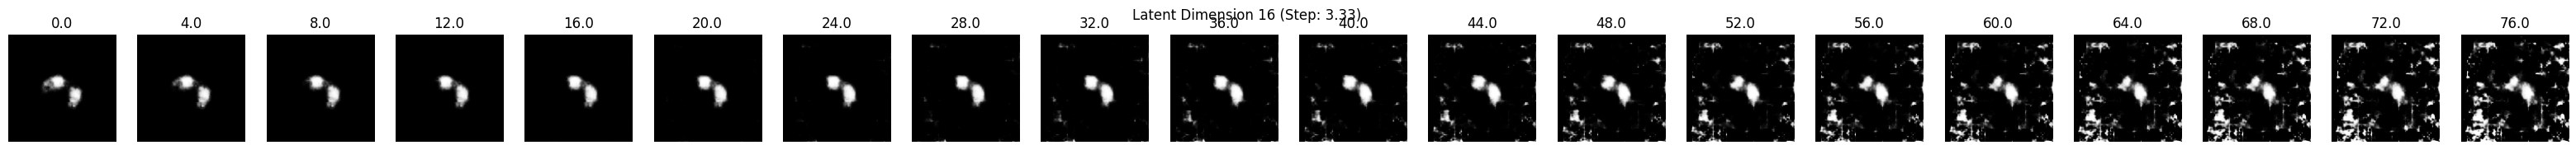

Generating images by varying latent dimension 17


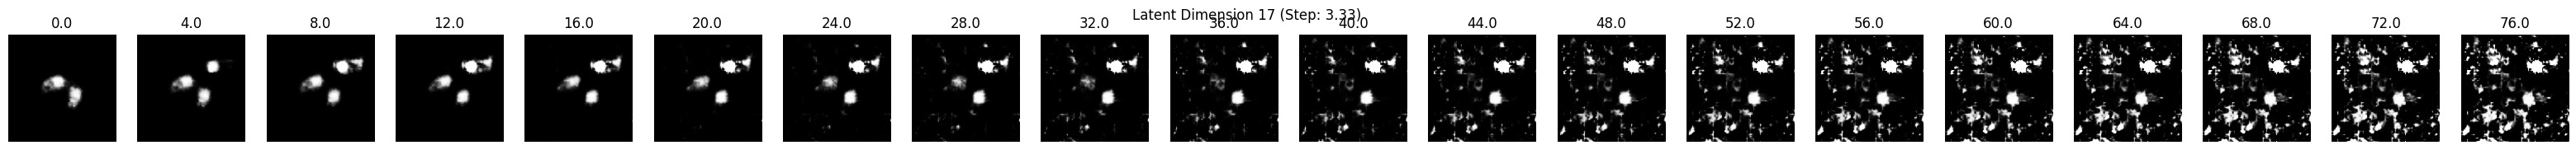

Generating images by varying latent dimension 18


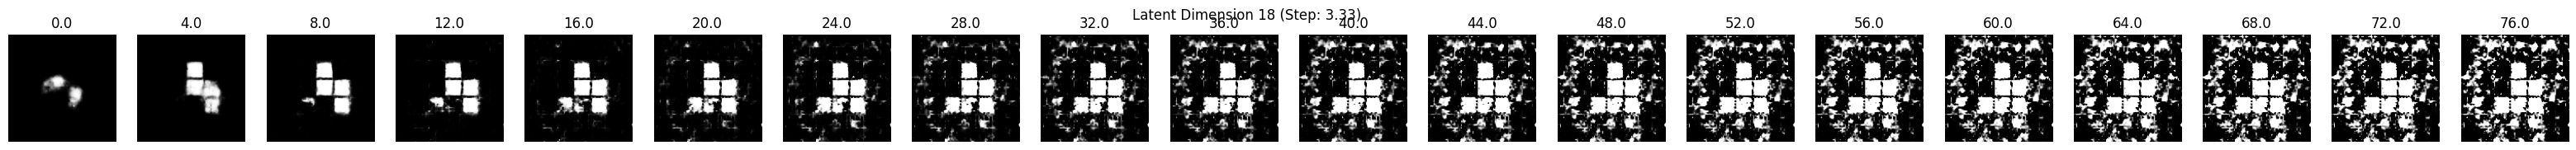

Generating images by varying latent dimension 19


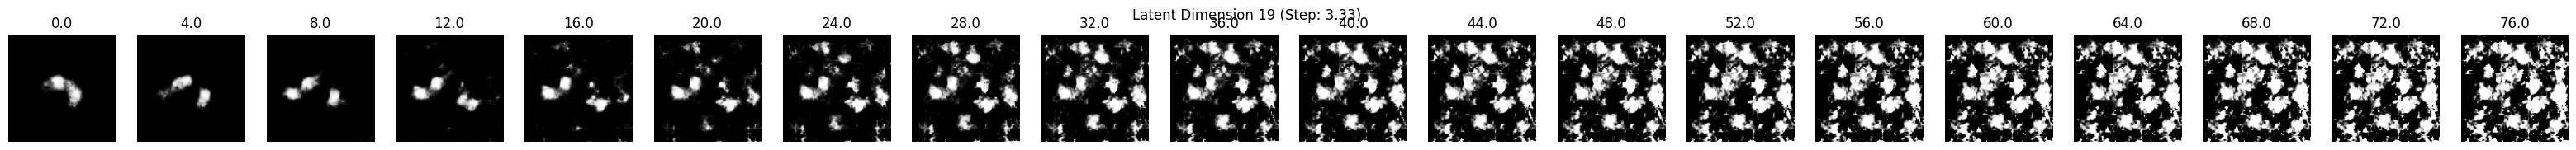

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def generate_images_along_latent(model, start_latent_vector, latent_dim_index, steps=10, span=3.0):
    images = []
    latent_values = np.linspace(0, span, steps)

    for value in latent_values:
        current_latent_vector = np.copy(start_latent_vector)
        current_latent_vector[latent_dim_index] = value

        current_latent_vector_batch = np.expand_dims(current_latent_vector, axis=0)

        generated_image = model.decode(current_latent_vector_batch)
        generated_image = tf.squeeze(generated_image).numpy()

        images.append((generated_image, value))

    return images

latent_dims = model.latent_dims
random_latent_vector = np.random.normal(size=(latent_dims,))

start_image = model.decode(np.expand_dims(random_latent_vector, axis=0))
start_image = tf.squeeze(start_image).numpy()

for dim_index in range(min(latent_dims, 20)):
    print(f"Generating images by varying latent dimension {dim_index}")
    generated_images = generate_images_along_latent(
        model,
        random_latent_vector,
        dim_index,
        steps=20,
        span=76
    )

    plt.figure(figsize=(len(generated_images) * 2, 2))
    for i, (img, value) in enumerate(generated_images):
        plt.subplot(1, len(generated_images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'{value:.1f}')

    plt.suptitle(f'Latent Dimension {dim_index} (Step: {30 / (10 - 1):.2f})')
    plt.show()


In [70]:
# cosine similarity and confusion matrices
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier

In [63]:
all_latent_vectors

<tf.Tensor: shape=(32, 64), dtype=float32, numpy=
array([[-1.00474   , -0.17447037,  0.12376502, ..., -0.19487238,
         0.00647274,  0.70004296],
       [-0.06651402, -0.07722119,  0.248605  , ..., -0.05299753,
        -0.11385199,  0.64786035],
       [ 0.46678382, -0.07535296,  0.00785518, ..., -0.33997762,
        -0.49002406,  0.33893198],
       ...,
       [ 1.1257595 ,  0.57531303, -0.52109385, ..., -0.44454885,
         2.3239818 , -0.18025312],
       [ 0.1429922 ,  0.70423996,  0.3026016 , ..., -0.13278872,
         0.5940597 ,  0.00575912],
       [ 1.6221133 ,  0.5899943 , -1.7391257 , ..., -0.17663239,
         0.5325861 ,  1.0704095 ]], dtype=float32)>

In [66]:
def curr_activation(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*x+b))
a = 40.0
b = a * 0.8

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_44
Received: inputs=('Tensor(shape=(16, 128, 128, 1))', 'Tensor(shape=(16,))')
  warnings.warn(msg)


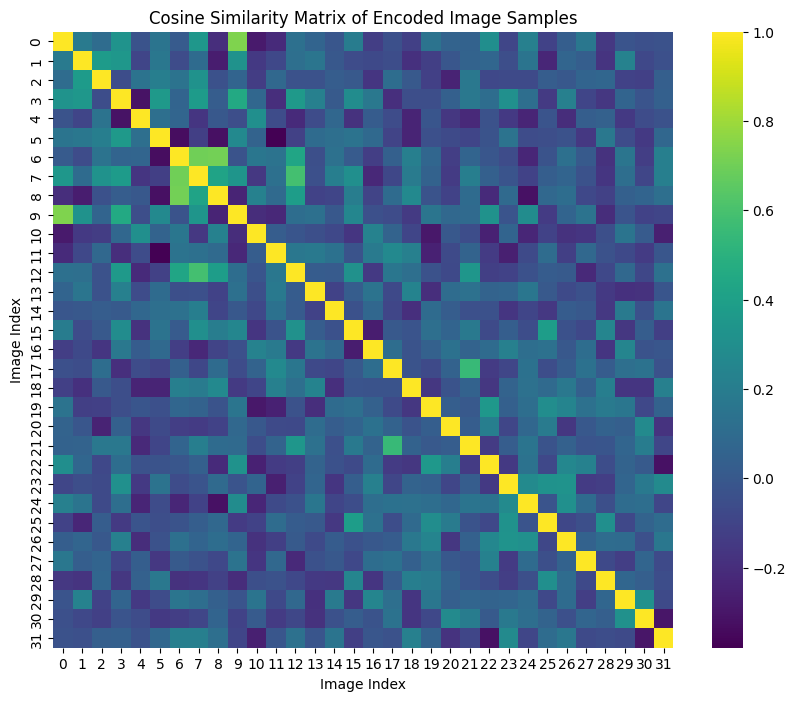

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get a batch of images from train and test datasets
train_images_sample = next(iter(train_ds.take(1)))
test_images_sample = next(iter(test_ds.take(1)))

# Encode the image samples
train_mu, _, _, _ = model.encode(train_images_sample)
test_mu, _, _, _ = model.encode(test_images_sample)

# Concatenate the latent representations for comparison
all_latent_vectors = tf.concat([train_mu, test_mu], axis=0)

# Calculate cosine similarity between all pairs of latent vectors
similarity_matrix = cosine_similarity(all_latent_vectors.numpy())

similarity_act = curr_activation(similarity_matrix, a, b)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis', fmt=".2f") # annot=True can clutter for large matrices
plt.title('Cosine Similarity Matrix of Encoded Image Samples')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.show()


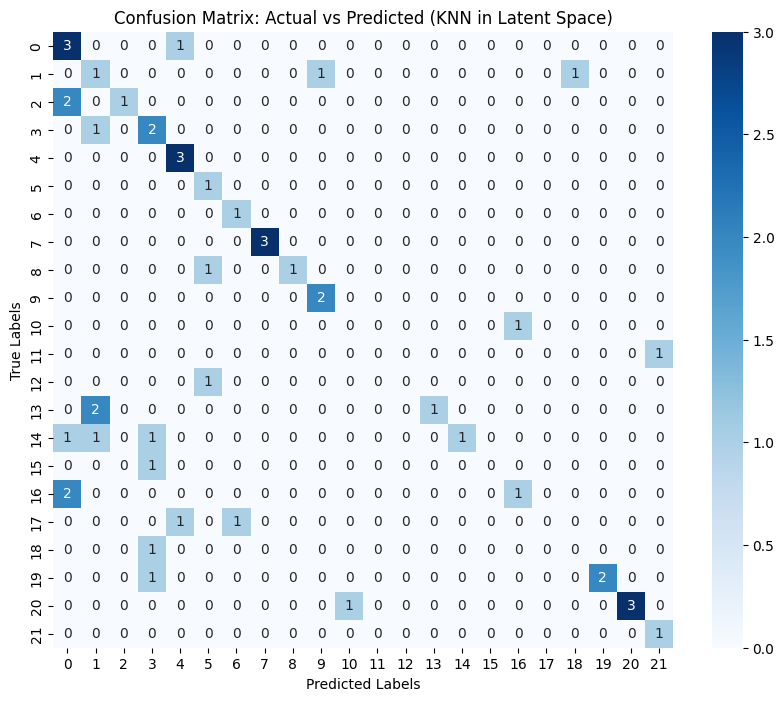

In [71]:
# Load all images and labels from the dataset
all_images = []
all_labels = []

for images_batch, labels_batch in train_ds:
    all_images.append(images_batch.numpy())
    all_labels.append(labels_batch.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Encode all images to latent space
all_mu, _, _, _ = model.encode(all_images)
all_latents = all_mu.numpy()

# Select random test samples
num_test_samples = 50
indices = np.random.choice(len(all_latents), size=num_test_samples, replace=False)
test_latents = all_latents[indices]
test_labels = all_labels[indices]

# Remaining samples are training set for KNN
mask = np.ones(len(all_latents), dtype=bool)
mask[indices] = False
train_latents = all_latents[mask]
train_labels = all_labels[mask]

# Fit KNN on training latents
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(train_latents, train_labels)

# Predict labels for test latents
pred_labels = knn.predict(test_latents)

# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix: Actual vs Predicted (KNN in Latent Space)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [72]:
accuracy = np.mean(pred_labels == test_labels)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.5400


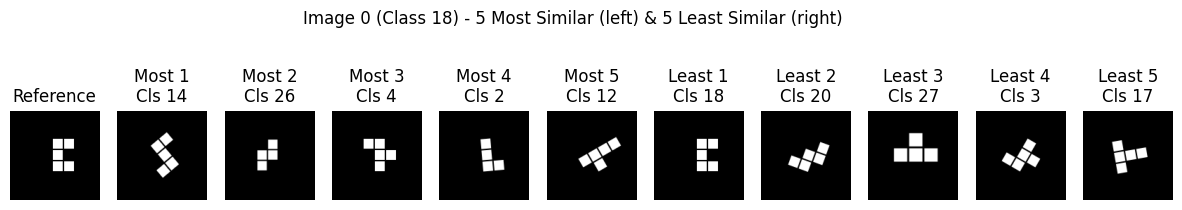

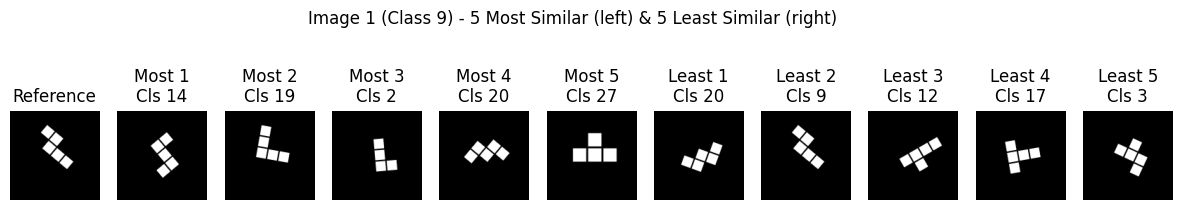

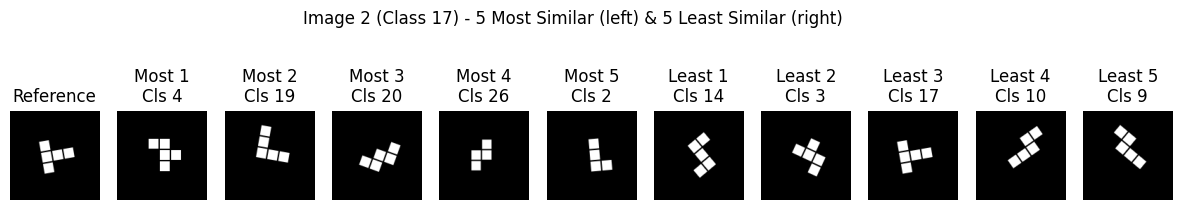

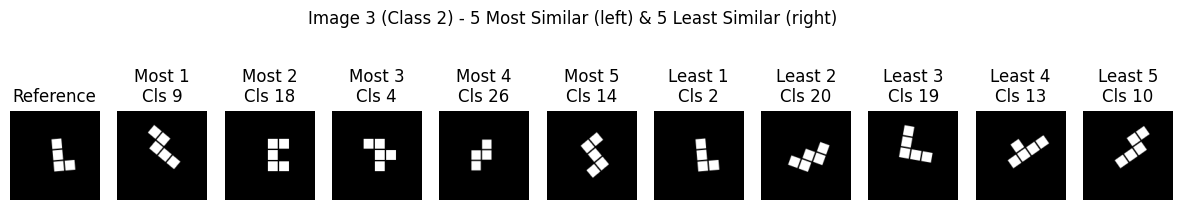

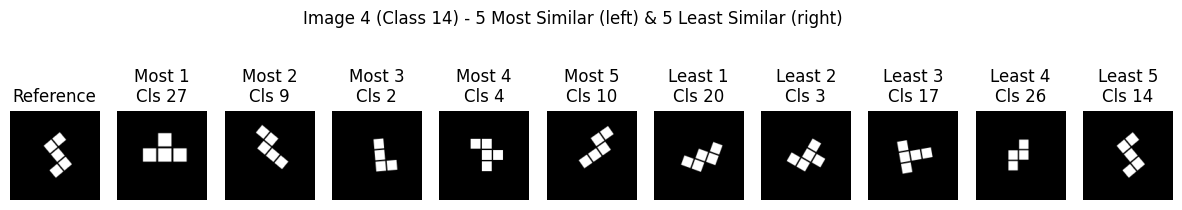

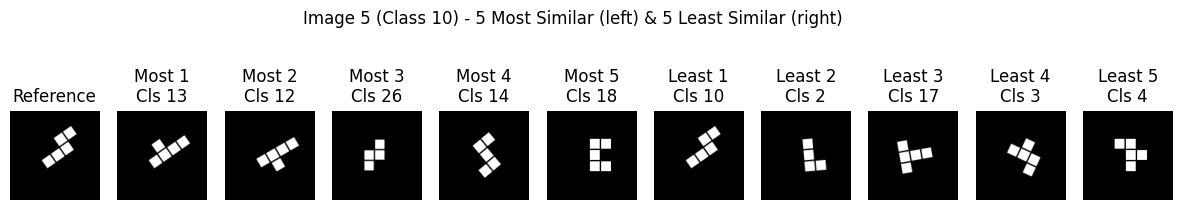

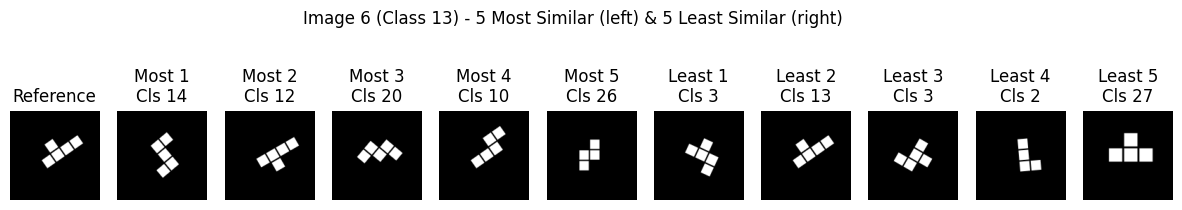

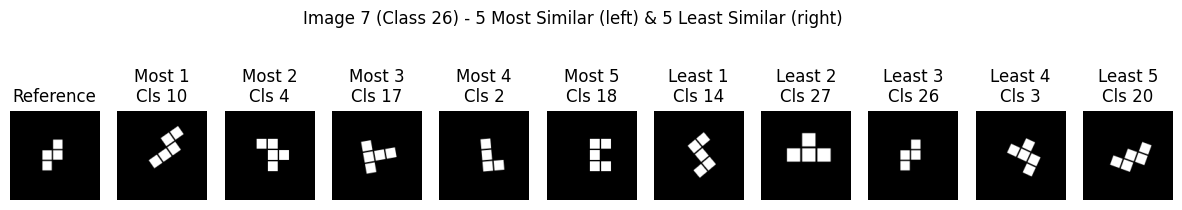

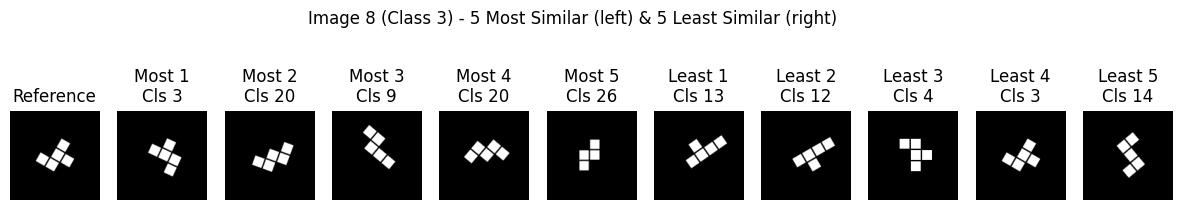

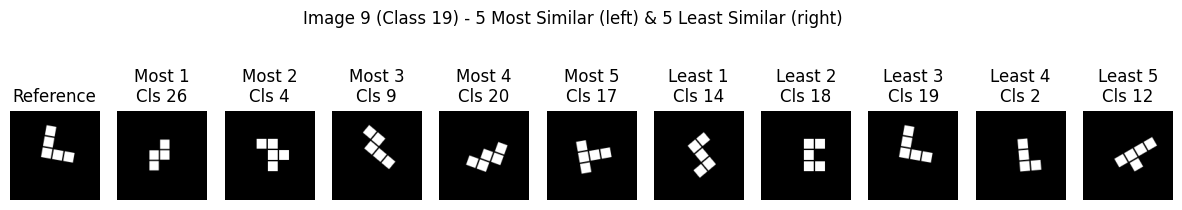

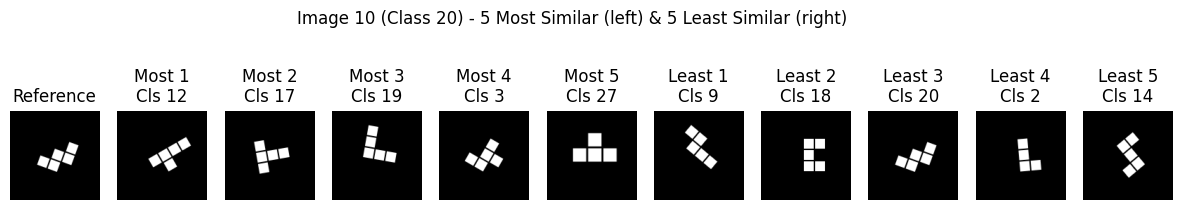

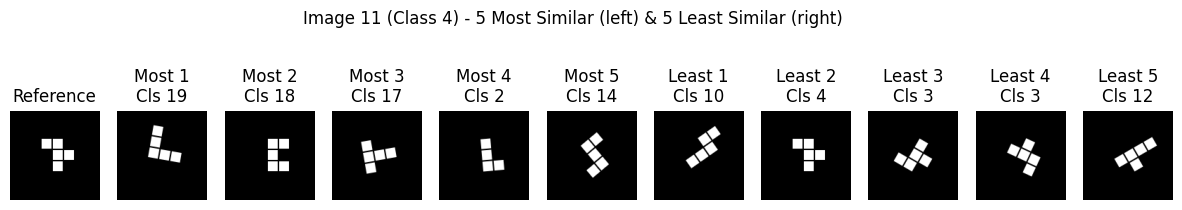

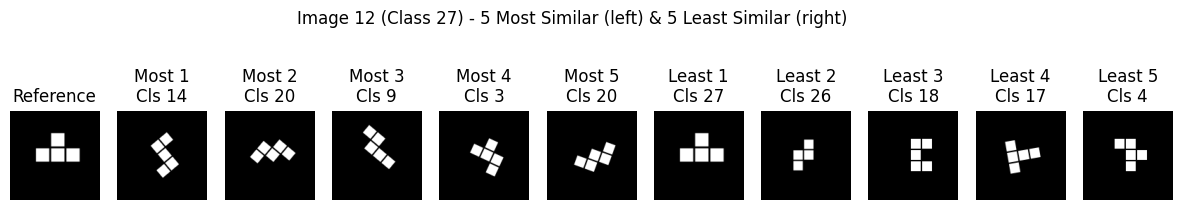

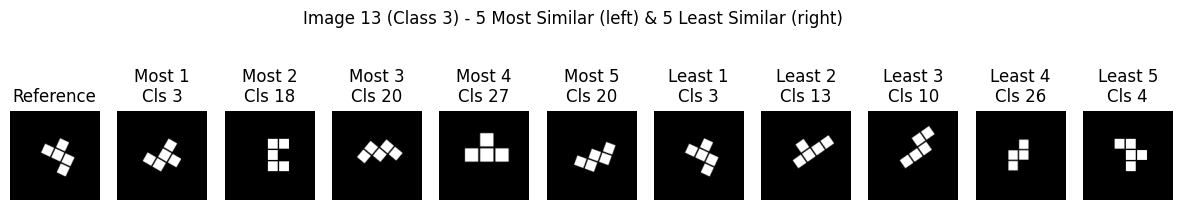

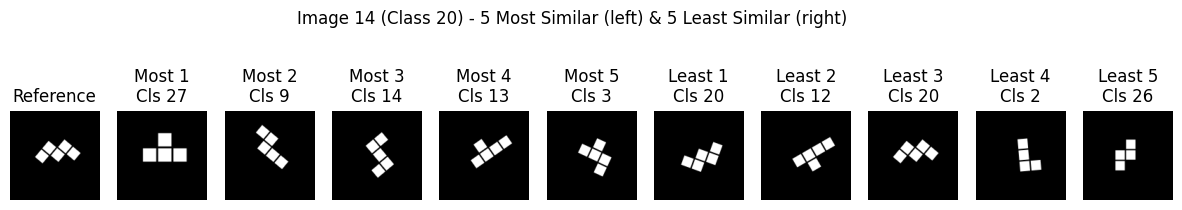

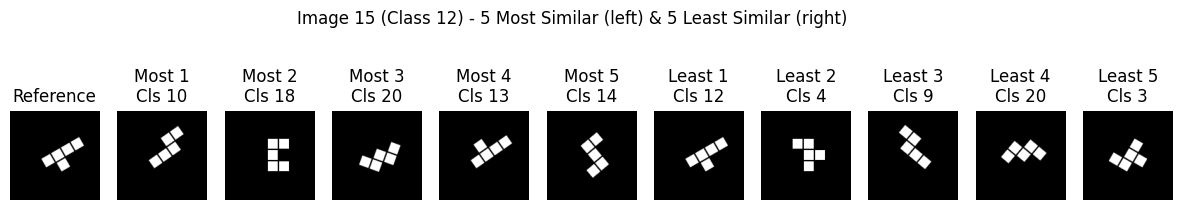

In [51]:
# Extract one batch from train dataset (images and labels)
train_images, train_labels = next(iter(train_ds.take(1)))

# Encode images to latent space
train_mu, _, _, _ = model.encode(train_images)
train_latents = train_mu.numpy()
labels = train_labels.numpy()
n = train_latents.shape[0]

sim_matrix = cosine_similarity(train_latents)

for i in range(n):
    sims = sim_matrix[i]
    # Exclude self by setting similarity to minimum
    sims[i] = -np.inf

    most_similar_idx = np.argpartition(-sims, 5)[:5]  # top 5 highest similarity
    least_similar_idx = np.argpartition(sims, 5)[:5]  # top 5 lowest similarity

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Image {i} (Class {labels[i]}) - 5 Most Similar (left) & 5 Least Similar (right)')

    # Plot reference image
    plt.subplot(1, 11, 1)
    plt.imshow(tf.squeeze(train_images[i]).numpy(), cmap='gray')
    plt.title('Reference')
    plt.axis('off')

    # Plot most similar
    for j, idx in enumerate(most_similar_idx, start=2):
        plt.subplot(1, 11, j)
        plt.imshow(tf.squeeze(train_images[idx]).numpy(), cmap='gray')
        plt.title(f'Most {j-1}\nCls {labels[idx]}')
        plt.axis('off')

    # Plot least similar
    for j, idx in enumerate(least_similar_idx, start=7):
        plt.subplot(1, 11, j)
        plt.imshow(tf.squeeze(train_images[idx]).numpy(), cmap='gray')
        plt.title(f'Least {j-6}\nCls {labels[idx]}')
        plt.axis('off')

    plt.show()